<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2025/blob/feat%2Frl-prac-part-3/Indaba_Learnathon_2025_RLHF_for_LLMs_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🤖 Reinforcement Learning from Feedback**

<a href="https://colab.research.google.com/drive/1NWkyBJf7Rfbja7U_WnVPk6VCpOlRUdQW?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2025. Apache License 2.0.

**Authors:** Tejumade Afonja and Avishkar Bhoopchand


### Reinforcement Learning (RL) Refresher

Whenever we have a *state*, take an *action*, and aim to find a *policy* that gives the best sequence of decisions (trajectory), RL becomes a useful tool.

<img src="https://drive.google.com/uc?export=view&id=11KnexfsPYIfHdncXwa8g-o8EGNZg0OBc" alt="agent_environment" width="300"/>


- State: the situation the agent finds itself in
- Action: the choice the agent makes
- Reward: feedback on how good or bad the action was
- Episode: single complete run of the task, from a starting state to a terminal state
- Trajectory: complete record of one episode
- Policy $\pi_{\theta}$: the agent's strategy which is a probability distribution over the actions given the state the agent is in

For example, in the snake game🐍 introduced in the [RL practical part 1](https://github.com/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/Reinforcement_Learning/Part_1/Solving_the_Snake_game_using_RL.ipynb):
- The state was the snake's position
- The action was moving `UP`$\uparrow$, `RIGHT`$\rightarrow$, `DOWN`$\downarrow$, `LEFT`$\leftarrow$
- Policy guided the movement of the snake
- and Reward told the snake whether it was moving in the right direction
- Episode is one full game, from the moment the snake appears until it crashes or learn how to play the game.
- Trajectory is a detailed replay of the game, log of every single observation, action, and reward in the order they happened

### From Snake🐍 to Text: Applying RL to train large language models (LLMs)

We are now going to use the exact same ideas from RL to train large language models (LLMs) like Gemini or ChatGPT through a method known as **Reinforcement Learning from Human Feedback (RLHF)** where:

- State → text so far (the prompt or conversation history)
- Action → the next token the model chooses
- Trajectory → the full sentence or response generated by the model
- Reward → a score representing how "good" the response is (based on some feedback mechanism - usually, human). This could be a score of how appropriate the style is for young audiences, or how helpful the answers are, or how safe it is, etc.
- Policy → the language model itself, which assigns probabilities to possible next tokens.


So in the same way as the snake's policy decided which direction to move, the LLM's policy decides which token to produce next.


There are three stages to training LLM from Feedback. Let's go through them one by one.

**Stage 1: Pretraining - Learning to Predict the Next Word**

As we have seen in [LLM practical part 1](https://github.com/deep-learning-indaba/indaba-pracs-2025/blob/main/practicals/LLMs/Part_1/Intro_to_LLM.ipynb), LLMs start with pretraining on massive text datasets. The objective is simple: predict the next token given the previous ones. The policy $\pi_{\theta}$ here (which is the pre-trained LLM) is trained to maximize the likelihood of correct next tokens:

Formally, given a sequence of tokens $x=(x_1, x_2, \cdots x_T)$, the model maximizes the log-likelihood:

$$
\ell_{\text{pretrain}}(\theta) = \sum_{t=1}^T \log \pi_{\theta} (x_t | x_{\lt t})
$$

> This makes the model very good at continuing texts. For example "once upon a ...", the model can continue it with "time".

But if you ask "Who is Nelson Mandela?", the model may just continue with words it has seen around "Mandela" instead of giving you a direct answer. It lacks *instruction-following* behavior. It is not able to correctly complete the task of answering the question asked.

**Stage 2: Supervised Fine-Tuning - Learning to Mimic Desired Behaviors**

To correct this, we apply supervised fine-tuning (SFT) using curated examples ([see LLM practical part 2](https://github.com/deep-learning-indaba/indaba-pracs-2025/tree/main/practicals/LLMs)).

- If we want a question & answer (Q&A) behavior: collect question-answer pairs
- If we want conversations like chatbots: collect dialogues

and so on.

The objective is the same maximum likelihood but now over _desired responses_ $y$ (the label) for a given prompt $x$:

$$
\ell_{\text{SFT}}(\theta) = \sum_{(x,y) \in D} \log \pi_\theta (y | x)
$$

Now the model learns to mimic correct _demostrations_ - like a student copying a teacher.

> But which teacher?




**Stage 3: Reinforcement Learning with Human Feedback - Aligning with Human Preferences**

> We agree with the Zen of Python (`import this` in a code cell :D) that there should only be one obvious way to do things - but when it comes to style, variation is the norm.

Different teachers deliver the same lecture in different ways; some answers cut straight to the point, others wander around a bit (like this explanation :)). What matters is that, depending on the user, one version may feel more useful than another.

SFT helps improve the model, but it still has important limitations:

- Creating good examples is expensive - human annotation are expensive
- Risks overfitting on small datasets are used and lack generalisation
- Unable to handle ambiguity
- Has limited reasoning capabilities
- Can't learn from negative examples

as a result:
- It can produce answers that are technically correct but not actually helpful.
- It may generate unsafe or even harmful outputs.
- It doesn't understand human preferences beyond what was explicitly shown in its training data

This is where reinforcement learning comes in.

We can think of the LLM as an agent in a reinforcement learning setup:

- State: the prompt given by the user.
- Action: the model's generated response.
- Reward: human feedback, such as ranking responses as better or worse.

By framing the problem this way, we can align the model's behavior more closely with what humans actually want.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/RLHF_diagram.svg/700px-RLHF_diagram.svg.png" />

### Reinforcing Token Preference with Binary Reward

Below, we'll create a simple environment to see the reinforcement "REINFORCE" algorithm in action. The environment includes 4 words and the goal is to train the model to always prefer the chosen answer.

> REINFORCE is the canonical example of a policy gradient method, and most other methods are built on top of it. The goal of policy gradient methods is to learn a policy $\pi$ that (1) takes in observations from the environment and then (2) returns the action that maximises the reward the agent obtains.


**NOTE:** The example is just for demonstration purpose, in practise, you would not use reinforcement learning for a simple task like this. Infact, the REINFORCE objective ends up behaving very similarly to a cross-entropy loss with one-hot target (this is the loss used for supervised fine-tuning), just less efficient because it relies on sampling rather than comparing against the model's full output distribution.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, HTML

In [2]:
vocab = ["blue", "green", "dog", "cat"]

In [3]:
def get_reward(action, preferred_action):
  """Reward is +1 if action==preferred_action else 0"""
  return 1 if vocab[action] == preferred_action else 0


class PolicyNetwork(nn.Module):
  def __init__(self, vocab_size):
    super(PolicyNetwork, self).__init__()
    # Takes in one token at a time and output a
    # probability distribution over the vocabulary size.
    self.fc = nn.Linear(1, vocab_size)

  def forward(self, x):
    x = self.fc(x)
    return F.softmax(x, dim=1)

When you run the code cell below, the plot shows how the policy is learning to reinforce the correct answer.

You can change the correct answer to reinforce by clicking the button:

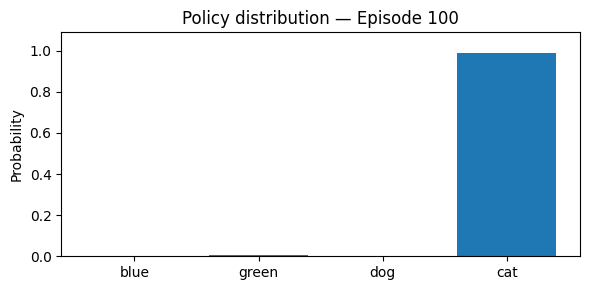

In [4]:
correct_answer = "cat" #@param ["blue", "green", "dog", "cat"]

print(f"REINFORCING: {correct_answer}")

policy = PolicyNetwork(len(vocab))
optimizer = optim.Adam(policy.parameters(), lr=0.1)

n_episodes = 100
losses = []
update_every = 1   # update the plot every N episodes

# Code for interactive plot
plt.ion()
fig, ax = plt.subplots(figsize=(6,3))
state = torch.tensor([[0.0]])
probs = policy(state).detach().numpy()[0]
bars = ax.bar(vocab, probs)
ax.set_ylim(0, 1)
ax.set_ylabel("Probability")
title = ax.set_title("Initial policy distribution (episode 0)")
plt.tight_layout()
plt.show()
#

for episode in range(n_episodes):

  # 1. State (input)
  state = torch.tensor([[0.0]]) # dummy state

  # 2. Sample action from policy
  probs = policy(state)
  dist = torch.distributions.Categorical(probs)
  action = dist.sample()

  # 3. Get reward from environment
  reward = get_reward(action.item(), correct_answer)

  # 4. Compute loss = -log_prob * reward  [Reinforce objective]
  loss = -dist.log_prob(action) * reward

  # 5. Update policy
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Visualize initial action distribution before training
  state = torch.tensor([[0.0]])
  probs = policy(state).detach().numpy()[0]

  # Update animation occasionally
  if (episode + 1) % update_every == 0 or episode == 0:
        # update bars
        with torch.no_grad():
            current_probs = policy(state).detach().numpy()[0]
        for bar, p in zip(bars, current_probs):
            bar.set_height(p)
        ax.set_ylim(0, max(0.6, current_probs.max() * 1.1))
        title.set_text(f"Policy distribution — Episode {episode+1}")

        # clear and re-display (works well in notebooks & Colab)
        clear_output(wait=True)
        display(fig)

  losses.append(loss.item())

# Turn off interactive mode and show final figure
plt.ioff()
plt.show()

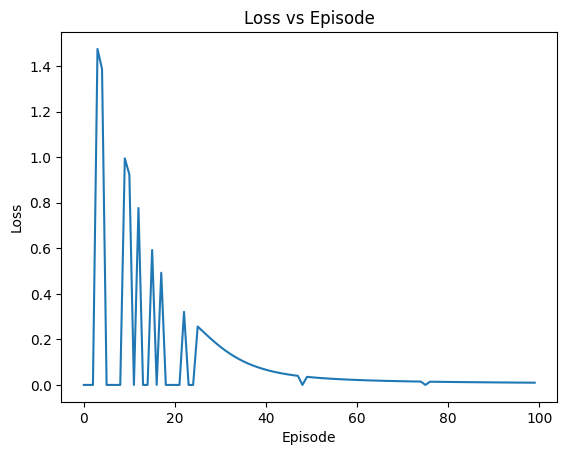

Learned probabilities: {'blue': 0.0023751610424369574, 'green': 0.004002835601568222, 'dog': 0.0032165730372071266, 'cat': 0.9904053807258606}


In [5]:
# Plot loss
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss vs Episode')
plt.show()

with torch.no_grad():
  state = torch.tensor([[0.0]])
  probs = policy(state)
  print("Learned probabilities:", {vocab[i]: float(p) for i, p in enumerate(probs[0])})

What did you observe?

- At the start, the policy picks word randomly
- Over time, REINFORCE increases the probability of choosing the `correct_answer`
- After training, `correct_answer` has the highest probability of being chosen

## Reinforcement Learning with Human Feedback

Below, we will demonstrate the RLHF process introduced in the [lecture slide](https://docs.google.com/presentation/d/e/2PACX-1vQPBoWFu7pRDYyfOUtFhvSQzByneFKyo7NYSzjhzfRG-s8CWrCJj3CtQOYLbzCYVHuEhQnh3fkIysP_/pub?start=false&loop=false&delayms=3000&slide=id.g2f6a0c0c73c_0_0) by Avishkar. We will walk through each step of the pipeline:

1. **Collect human feedback.**
We will show a simple example of how human preference data can be collected to express the behavior we want the model to learn.

2. **Train a reward model.**
We use the preference dataset from Step 1 to train a reward model that scores model outputs according to human preference.

3. **Optimise the policy with RL.**
Finally, we optimise the policy using the REINFORCE algorithm (and variants), guided by the reward model.

We will add a Step 0:

**Supervised fine-tune (SFT) a base model.**
We fine-tune a pre-trained LLM so that it can reasonably perform the task before applying RL. This gives us a strong starting policy.


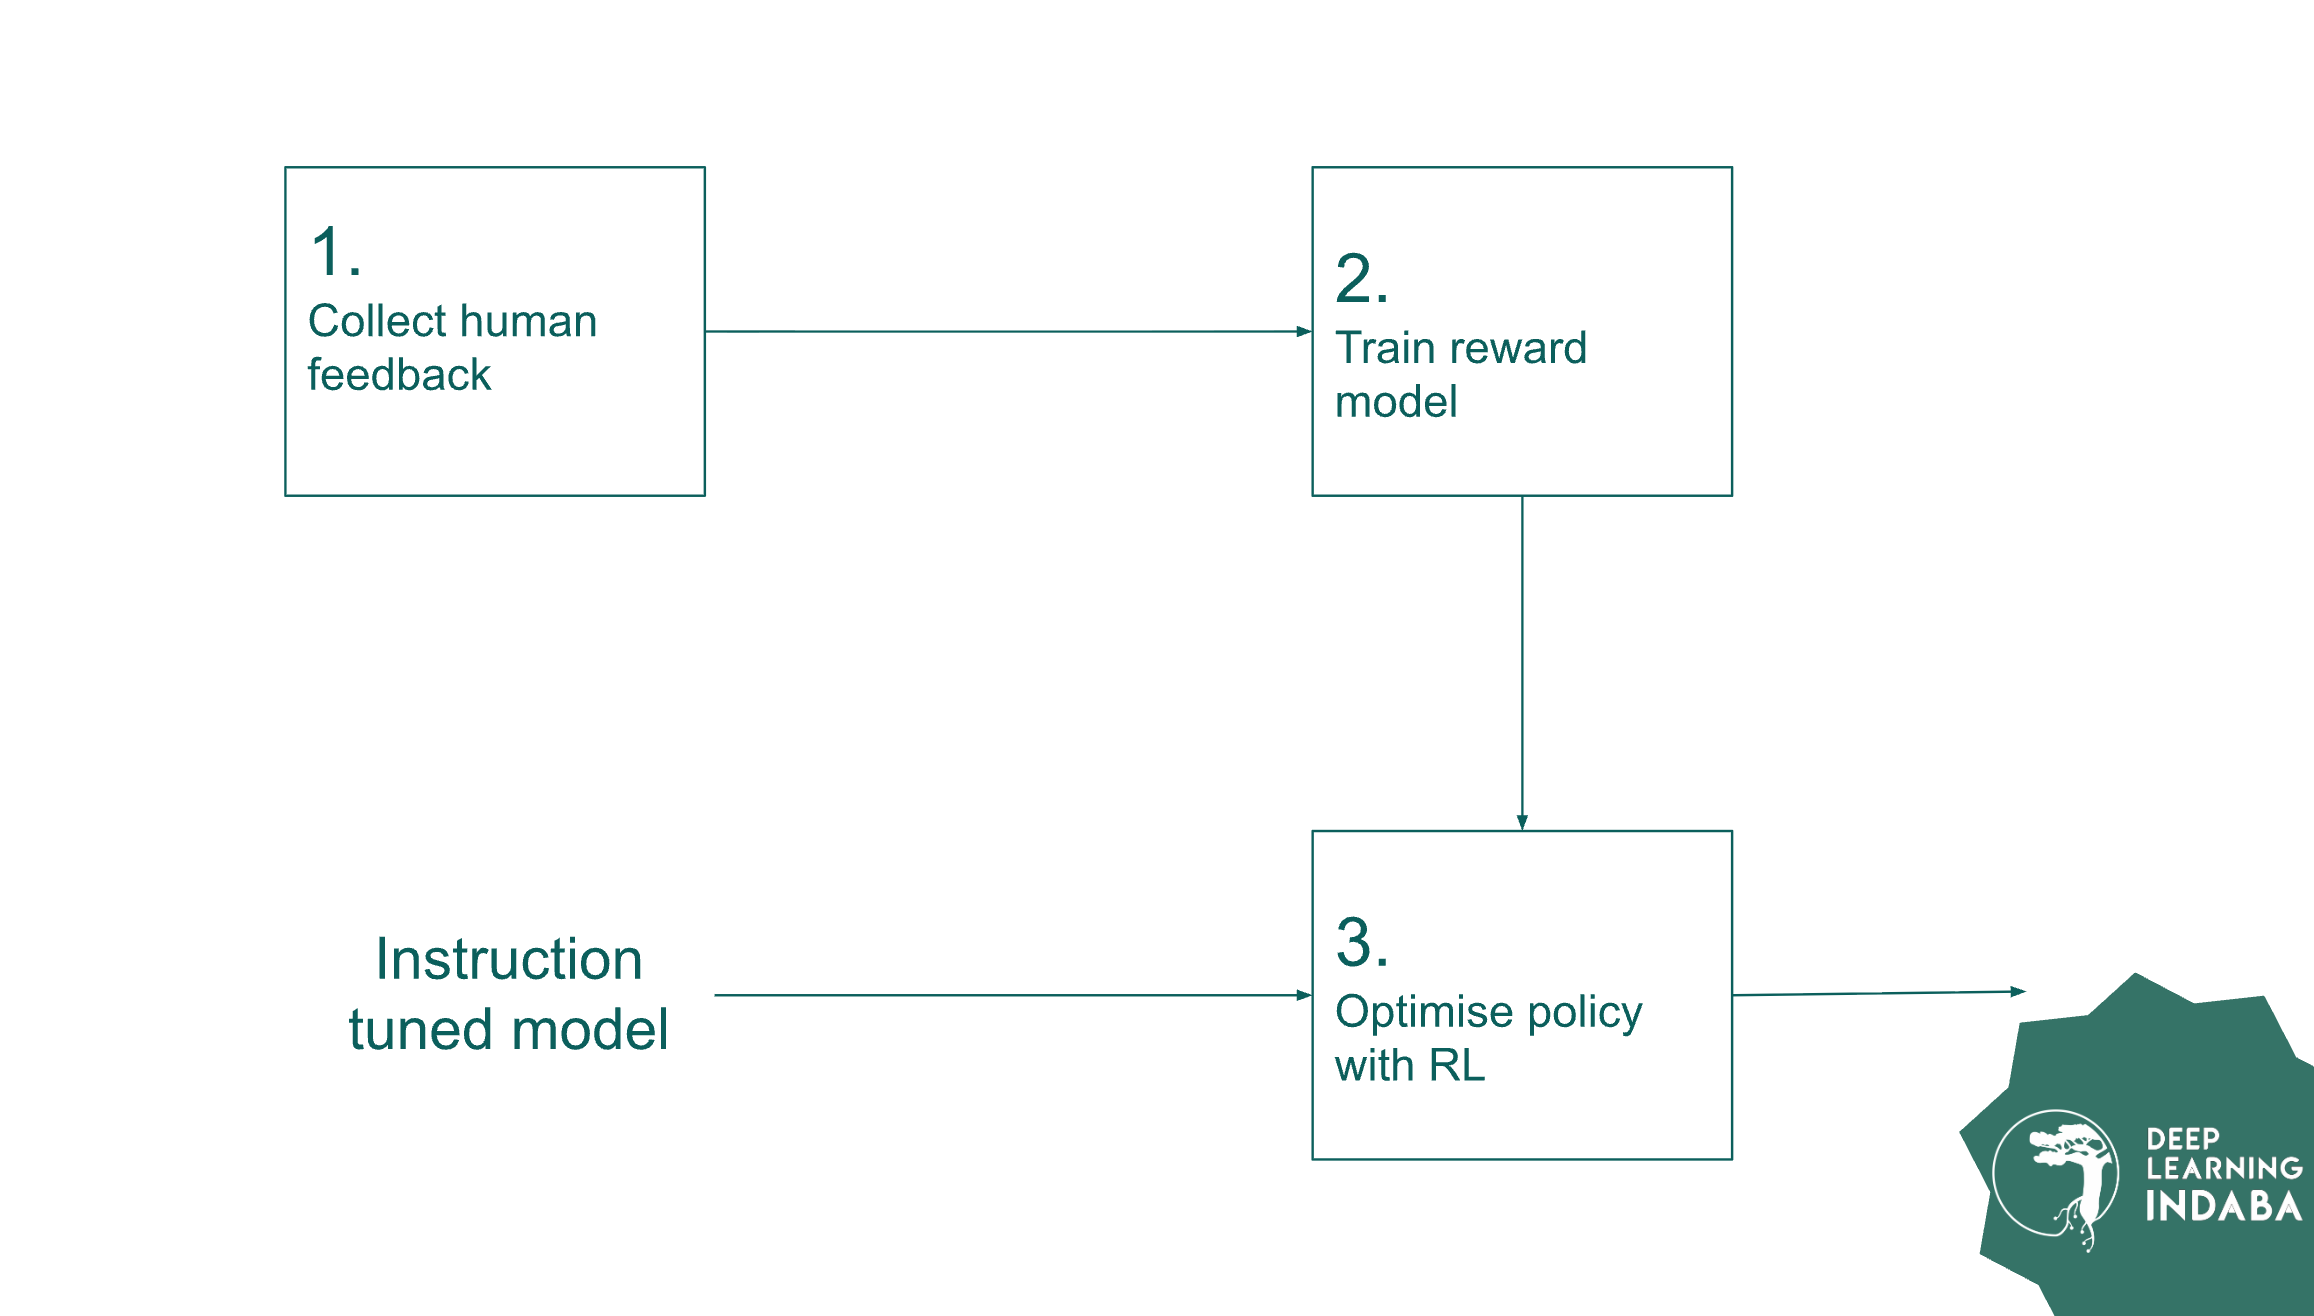


### Step 0: Supervised fine-tune (SFT) a base model

Suppose we have a base language model trained on internet text. It can predict the next token reasonably well, but it has not been trained to answer questions directly. For compute reasons, we will use the GPT-2 model in Colab. (You are encouraged to try larger models if you want to extend this work.)


If we prompt the pre-trained GPT-2 with `Explain Reinforcement Learning`, you will notice it does not answer properly. This is expected: GPT-2 is not an instruction-tuned model.

**NOTE:** Most modern models have already undergone supervised fine-tuning, so this step is usually not necessary but here we include it so you can see the full RLHF pipeline.

The code below shows how to sample from a pre-trained model.

In [6]:
def print_sample(prompt, sample, model_name="", generation_time=None):
    if prompt in sample:
      sample = sample.split(prompt)[1].rstrip()

    html = f"""
    <div style="font-family:monospace; border:1px solid #ccc; padding:10px">
        <div><b style='color:teal;'>🤖 Model:</b> <span>{model_name}</span></div>
        {'<div><b style="color:orange;">⏱️ Generation Time:</b> ' + f'{generation_time:.2f}s</div>' if generation_time else ''}
        <div><b style='color:green;'>📝 Prompt:</b> {prompt}</div>
        <div><b style='color:purple;'>✨ Generated:</b> {sample}</div>
    </div>
    """
    display(HTML(html))


def generate_text(model, inputs, max_new_tokens=30):
  model.eval()
  model = model.to('cpu')
  outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=True, top_k=50)
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return response

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
pt_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

prompt = "Explain Reinforcement Learning."
inputs = tokenizer(prompt, return_tensors="pt")

response = generate_text(pt_model, inputs, max_new_tokens=30)

clear_output() # clears output.
print_sample(prompt, response, model_name)

The pre-trained model is unable to answer the question, as shown in the output above. To turn it into a useful model that can respond to such instructions, we need to fine-tune it with supervised examples. To do this, we construct a small demonstration dataset of definitions of reinforcement learning, ranging from simple to more technical descriptions, and fine-tune the model.

Below, we construct a small instruction dataset centered on the prompt `Explain Reinforcement Learning` to teach the model how to provide appropriate answers.

In [8]:
# @title Create Instruction Dataset for SFT.
sft_examples = [
    # ---------------------- SIMPLE LEVEL ----------------------
    {
        "instruction": "Explain reinforcement learning simply.",
        "response": "Reinforcement learning is when a computer learns by trying things and seeing what happens. If it makes a good choice, it gets a reward. If it makes a bad choice, it gets a penalty. Over time, it figures out which actions work best."
    },
    {
        "instruction": "Explain reinforcement learning like I'm new to machine learning.",
        "response": "Reinforcement learning is a way for a computer to learn by doing. It tries actions in an environment and gets feedback. With enough practice, it learns what actions lead to better results."
    },
    {
        "instruction": "Explain reinforcement learning with an everyday example.",
        "response": "Reinforcement learning is like teaching a pet. When the pet behaves well, you give it a treat. After repeating this, it learns which actions lead to rewards. An RL agent learns the same way from rewards."
    },
    {
        "instruction": "Explain the idea behind reinforcement learning to someone with no technical background.",
        "response": "Reinforcement learning is learning from experience. When you do something and it turns out well, you're more likely to do it again. A computer agent works the same way by repeating actions that lead to rewards."
    },
    {
        "instruction": "Give an intuitive explanation of reinforcement learning.",
        "response": "Reinforcement learning lets a system learn by experimenting. Each action gives a reward or penalty, and the system uses that feedback to improve its choices."
    },

    # ---------------------- MID LEVEL ----------------------
    {
        "instruction": "Explain reinforcement learning.",
        "response": "Reinforcement learning is a type of machine learning where an agent interacts with an environment by taking actions, observing outcomes, and receiving rewards. Over time, the agent learns a policy that leads to high long-term rewards."
    },
    {
        "instruction": "Explain reinforcement learning in simple terms.",
        "response": "Reinforcement learning teaches an agent to make better choices by rewarding good actions and discouraging bad ones. Over many trials, the agent figures out what works best."
    },
    {
        "instruction": "Explain the concept of reinforcement learning to a beginner.",
        "response": "Reinforcement learning trains an agent through trial and error. The agent takes an action, gets a reward, and adjusts its strategy. The goal is to earn more rewards over time."
    },
    {
        "instruction": "Explain reinforcement learning using the terms agent, environment, and reward.",
        "response": "In reinforcement learning, an agent takes actions inside an environment. The environment responds by giving a new state and a reward. The agent uses this feedback to learn a policy that earns the most reward."
    },
    {
        "instruction": "Explain reinforcement learning step by step.",
        "response": "1. The agent observes the current state.\n2. It chooses an action.\n3. The environment changes state and gives a reward.\n4. The agent updates its policy or value estimate.\n5. By repeating this loop many times, it learns effective behavior."
    },
    {
        "instruction": "Explain reinforcement learning concisely.",
        "response": "Reinforcement learning is a process where an agent learns to make decisions by trying actions and receiving rewards, improving its strategy over time."
    },
    {
        "instruction": "Give a detailed explanation of reinforcement learning.",
        "response": "Reinforcement learning trains an agent to make sequential decisions through interactions with an environment. The problem is often modeled as a Markov Decision Process involving states, actions, rewards, and policies. The agent’s goal is to maximize expected cumulative reward using methods such as value-based learning or policy optimization."
    },
    {
        "instruction": "Explain reinforcement learning for a student in data science.",
        "response": "Reinforcement learning focuses on learning behavior policies through repeated interactions with an environment. It uses concepts like states, actions, rewards, and policies and is often formalized as an MDP. Algorithms include Q-learning, SARSA, policy gradients, and actor-critic methods."
    },
    {
        "instruction": "Explain reinforcement learning using an analogy.",
        "response": "Reinforcement learning is like playing a video game without instructions. You try different actions, see your score change, and learn through trial and error which moves help you win."
    },

    # ---------------------- ADVANCED LEVEL ----------------------
    {
        "instruction": "Explain reinforcement learning in technical terms.",
        "response": "Reinforcement learning is a sequential decision-making framework typically modeled as a Markov Decision Process (MDP). The objective is to find a policy π(a|s) that maximizes expected discounted return G = Σ γⁿ rₙ. Approaches include value-based methods like Q-learning, which estimate action-value functions, and policy-based methods, such as policy gradients, which directly optimize π using gradient ascent on expected returns."
    },
    {
        "instruction": "Explain reinforcement learning with a focus on rewards.",
        "response": "Reinforcement learning centers on maximizing cumulative rewards. Each action leads to immediate reward rₜ and influences future rewards through state transitions. Agents learn strategies that optimize long-term return, not just instant feedback, often by estimating value functions or optimizing parameterized policies."
    },
    {
        "instruction": "Explain what reinforcement learning means in artificial intelligence.",
        "response": "In AI, reinforcement learning refers to algorithms that learn optimal decision-making policies through interaction. An agent observes states, takes actions, and receives scalar rewards. By estimating value functions or using policy optimization, the agent converges toward behavior that maximizes long-term expected return."
    },
    {
        "instruction": "Give a short technical explanation of reinforcement learning.",
        "response": "Reinforcement learning solves MDPs by learning policies that maximize expected cumulative reward. Agents use Bellman equations, value iteration, temporal-difference learning, or gradient-based policy optimization to approximate optimal behavior."
    }
]



In [9]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

sft_df = pd.DataFrame(sft_examples)
sft_df.sample(5)

,instruction,response
3,Explain the idea behind reinforcement learning to someone with no technical background.,"Reinforcement learning is learning from experience. When you do something and it turns out well, you're more likely to do it again. A computer agent works the same way by repeating actions that lead to rewards."
5,Explain reinforcement learning.,"Reinforcement learning is a type of machine learning where an agent interacts with an environment by taking actions, observing outcomes, and receiving rewards. Over time, the agent learns a policy that leads to high long-term rewards."
8,"Explain reinforcement learning using the terms agent, environment, and reward.","In reinforcement learning, an agent takes actions inside an environment. The environment responds by giving a new state and a reward. The agent uses this feedback to learn a policy that earns the most reward."
1,Explain reinforcement learning like I'm new to machine learning.,"Reinforcement learning is a way for a computer to learn by doing. It tries actions in an environment and gets feedback. With enough practice, it learns what actions lead to better results."
16,Explain what reinforcement learning means in artificial intelligence.,"In AI, reinforcement learning refers to algorithms that learn optimal decision-making policies through interaction. An agent observes states, takes actions, and receives scalar rewards. By estimating value functions or using policy optimization, the agent converges toward behavior that maximizes long-term expected return."


#### Supervised fine-tuning on instruction dataset

We fine-tune on the instruction-tuned dataset on GPT2 model.

In [10]:
from datasets import Dataset

sft_dataset = Dataset.from_pandas(sft_df)
sft_dataset

Dataset({
    features: ['instruction', 'response'],
    num_rows: 18
})

In [11]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token

MAX_LENGTH = 128
def tokenize(batch):
    texts = [
        f"{p} {pref}"
        for p, pref in zip(batch["instruction"], batch["response"])
    ]
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

tokenized_dataset = sft_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

In [12]:
for idx, inputs in enumerate(tokenized_dataset):
  print(tokenizer.decode(inputs['input_ids']))
  if idx == 5:
    break

Explain reinforcement learning simply. Reinforcement learning is when a computer learns by trying things and seeing what happens. If it makes a good choice, it gets a reward. If it makes a bad choice, it gets a penalty. Over time, it figures out which actions work best.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|

We create a dataloader for training the model below:

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 5
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
dataloader = DataLoader(tokenized_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
for i in dataloader:
  print(i['input_ids'][0])
  print(tokenizer.decode(i['input_ids'][0]))
  break

tensor([18438,   391, 37414,  4673,   287,  6276,  2846,    13, 22299, 13442,
         4673,   318,   257, 35582,  2551,    12,  8601,  9355,  6032, 29563,
          355,   257,  2940,   709, 26423, 10854,   357,    44,  6322,   737,
          383,  9432,   318,   284,  1064,   257,  2450, 18074,   222,     7,
           64,    91,    82,     8,   326, 12991,  4340,  2938, 29686,  1441,
          402,   796,  7377,    96,  7377,   111, 46256,   123,   374,   158,
          224,   247,    13, 20010,  3694,  2291,  1988,    12,  3106,  5050,
          588,  1195,    12, 40684,    11,   543,  8636,  2223,    12,  8367,
         5499,    11,   290,  2450,    12,  3106,  5050,    11,   884,   355,
         2450,  3915,  2334,    11,   543,  3264, 27183, 18074,   222,  1262,
        31312, 37137,   319,  2938,  5860,    13, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

In [15]:
from transformers import GPT2LMHeadModel

sft_model = GPT2LMHeadModel.from_pretrained("gpt2")
sft_model.resize_token_embeddings(len(tokenizer))


Embedding(50257, 768)

Below, finetune the model:

In [16]:
import torch
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"
sft_model.to(device)

optimizer = AdamW(sft_model.parameters(), lr=5e-5)

sft_model.train()
for epoch in range(10):
    # We train with a small number of epochs to avoid the risk of overfitting
    # Try to increase this to see how the model behaves.
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = sft_model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} Loss: {loss.item()}")

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch 0 Loss: 2.1412556171417236
Epoch 1 Loss: 1.675266981124878
Epoch 2 Loss: 1.7131190299987793
Epoch 3 Loss: 1.1993358135223389
Epoch 4 Loss: 0.9009931087493896
Epoch 5 Loss: 1.2830108404159546
Epoch 6 Loss: 0.9375125169754028
Epoch 7 Loss: 0.7624683976173401
Epoch 8 Loss: 0.5146708488464355
Epoch 9 Loss: 0.7988702058792114


In [17]:
prompt = "Explain reinforcement learning."
inputs = tokenizer(prompt, return_tensors="pt")

response = generate_text(sft_model, inputs)

clear_output() # clears output.
print_sample(prompt, response, model_name)

In [18]:
prompt = "Explain reinforcement learning simply."
inputs = tokenizer(prompt, return_tensors="pt")

response = generate_text(sft_model, inputs)

clear_output() # clears output.
print_sample(prompt, response, model_name)

In [19]:
prompt = "What is reinforcement learning?"
inputs = tokenizer(prompt, return_tensors="pt")

response = generate_text(sft_model, inputs)

clear_output() # clears output.
print_sample(prompt, response, model_name)

In [20]:
prompt = "Tell me about reinforcement learning."
inputs = tokenizer(prompt, return_tensors="pt")

response = generate_text(sft_model, inputs)

clear_output() # clears output.
print_sample(prompt, response, model_name)

With just a few examples, the pre-trained model has already improved significantly after fine-tuning on our instruction dataset about answering questions on reinforcement learning. It is also able to answer questions it was not explicitly trained on. For example, even though our dataset did not include an instruction like "Tell me about reinforcement learning", the model can still generate a coherent answer. You can try other prompts to see how well it generalizes.

### Step 1: Collecting Human Feedback

Now we return to Step 1. Suppose what we really want is a model tailored for small children — one that explains reinforcement learning using very simple language. What would you do?


Suppose we want to explain reinforcement learning to a 5-year-old. We have two possible explanations:

**A**: Reinforcement learning is like teaching a dog tricks. When the dog does something good, it gets a treat. The dog learns to do more good things to get more treats

**B**: Reinforcement learning is a type of machine learning where an agent learns a policy to maximize cumulative rewards in a Markov Decision Process by taking actions based on states and receiving feedback from a reward function.

Which one do you prefer between A & B?

The example above is a simple illustration of how a preference dataset can be constructed. Below, we follow the same approach to collect a dataset of preferred and dispreferred responses for training a model to explain reinforcement learning simply.

We create pairs of responses, where each pair contains:

- Preferred response: a simple, potentially non-domain expert-friendly explanation that is easy to understand.

- Dispreferred response: a more technical or complex explanation that is harder for a general audience to follow.

This preference dataset will later be used to train a reward model that guides the model toward producing answers that match our desired style.

In [21]:
preference_examples = [
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "Reinforcement learning is like learning a skill by trying things out and noticing what works.",
        "dispreferred": "Reinforcement learning is a method where an agent improves through repeated feedback from its actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like playing a game and getting points for good moves, so over time you learn what gets the most points.",
        "dispreferred": "Reinforcement learning involves learning a behavior by receiving feedback signals from the environment."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like pressing a button on a toy and seeing a fun light, so you press it again because it feels good.",
        "dispreferred": "It is a framework where behavior improves based on the consequences of previous actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You try something, see the result, and repeat the actions that worked best.",
        "dispreferred": "Reinforcement learning uses feedback to adjust actions toward better long-term outcomes."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "Imagine learning to balance on a bike by trying, wobbling, and slowly figuring out what keeps you upright.",
        "dispreferred": "Learning happens gradually as actions that lead to better results are reinforced more strongly."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like solving a puzzle through trial and error and remembering the piece that finally fits.",
        "dispreferred": "RL improves decision-making by reinforcing successful patterns of behavior."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You get a small reward for a good choice, so next time you try to make the same good choice.",
        "dispreferred": "The method relies on rewards that encourage some behaviors and discourage others."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn from the good things that happen when you make good choices.",
        "dispreferred": "The system updates its strategy based on positive or negative feedback from actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "A robot gets a cheerful beep when it does the right step, so it repeats that step more often.",
        "dispreferred": "An agent adapts its behavior depending on how the environment responds to its actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like finding the best route up a slide by trying different steps.",
        "dispreferred": "The process gradually improves decisions by learning which actions lead to better outcomes."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "Like trying different crayons until you figure out which one makes the brightest color.",
        "dispreferred": "Reinforcement learning strengthens behaviors that produce positive results."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn which buttons make your toy sing.",
        "dispreferred": "The learner adjusts behavior based on repeated interactions with an environment."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "Try something, get a little reward, and do it again.",
        "dispreferred": "It updates actions by comparing the outcomes of different choices."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s learning by getting small hints from experience.",
        "dispreferred": "Actions that lead to better outcomes become more likely over time."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn what helps you win a simple game by practicing.",
        "dispreferred": "Reinforcement learning improves behavior through repeated practice and feedback."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like a guessing game where the world tells you when you are getting warmer.",
        "dispreferred": "RL is a way to improve actions by evaluating how helpful the results were."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You try, get a reward, and remember the good choice.",
        "dispreferred": "Good actions become more likely as their benefits are reinforced."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "Like learning the best way to build a sandcastle by experimenting with shapes.",
        "dispreferred": "Behavior is shaped by which outcomes are rewarded more often."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You repeat the things that get you smiles.",
        "dispreferred": "RL estimates which actions are expected to produce positive results."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like learning the safest path across a playground by trying several routes.",
        "dispreferred": "It compares different choices based on how rewarding they are."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn to stack blocks higher by practicing different methods.",
        "dispreferred": "Behavior is refined by repeatedly evaluating the outcomes of actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You get candy for cleaning up, so next time you clean up again.",
        "dispreferred": "RL encourages beneficial actions by rewarding them."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s learning by doing, not by reading instructions.",
        "dispreferred": "The agent gradually discovers better actions from direct experience."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn to aim a ball into a basket by trying throw after throw.",
        "dispreferred": "RL uses repeated practice to shape more effective behaviors."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You get gentle hints from the world that help you choose better next time.",
        "dispreferred": "Feedback from the environment determines which actions become preferred."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like trying different hiding spots until you find the one that really works.",
        "dispreferred": "Choices are strengthened or weakened depending on the consequences."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "When something good happens, you remember it and do it again.",
        "dispreferred": "RL gradually shifts behavior toward more rewarding actions."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn the best route through a maze by trying different paths.",
        "dispreferred": "The system evaluates each action based on how rewarding it is."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You keep what works and drop what doesn’t.",
        "dispreferred": "Actions with better outcomes are chosen more frequently over time."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn to pour juice without spilling by practicing.",
        "dispreferred": "RL methods adapt behavior by learning from trial and error."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn how to swing higher by trying different pushes.",
        "dispreferred": "Reinforcement learning refines actions based on results."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You find the best hiding place by practicing.",
        "dispreferred": "Actions that lead to better responses are more often repeated."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You get treats for doing something right.",
        "dispreferred": "RL strengthens responses that lead to rewards."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn the rules by seeing what happens each time.",
        "dispreferred": "The method uses feedback from actions to adjust future behavior."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You try things, see what helps, and do more of it.",
        "dispreferred": "RL is based on learning which actions produce desirable outcomes."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like finding the cups that stack well without falling.",
        "dispreferred": "The agent updates its choices based on how successful they have been."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn from small wins, like a game giving you stars.",
        "dispreferred": "Actions are evaluated based on how rewarding their results are."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s learning by exploring and noticing what works.",
        "dispreferred": "RL tracks which actions tend to lead to better rewards."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You figure out how to reach cookies on a shelf by trying different ways.",
        "dispreferred": "The approach identifies which strategies lead to better outcomes."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn by seeing which choices make things better.",
        "dispreferred": "RL compares the success of different choices to guide learning."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You try things and remember what helps you win.",
        "dispreferred": "The method evaluates how useful each action is over time."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like trial and error in daily life.",
        "dispreferred": "Over time, helpful behaviors become more common through reinforcement."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn how to jump rope by trying many times.",
        "dispreferred": "RL adjusts action choices based on repeated outcomes."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You aim a toy plane better by throwing it again and again.",
        "dispreferred": "Actions are refined by looking at their long-term effects."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn what jokes make friends laugh by trying different ones.",
        "dispreferred": "RL improves behavior by reinforcing positive responses."
    },

    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn from 'nice job' and 'try again' moments.",
        "dispreferred": "Feedback guides the agent toward more effective behavior."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like balancing blocks by trying different stacks.",
        "dispreferred": "RL evaluates how rewarding each action is and adjusts accordingly."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn to catch a ball by practicing again and again.",
        "dispreferred": "The system improves actions based on observed outcomes."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "You learn better choices by noticing what leads to good things.",
        "dispreferred": "RL identifies which actions tend to lead to more rewards."
    },
    {
        "instruction": "Explain reinforcement learning simply",
        "preferred": "It’s like learning the best way to get cookies—trying until something works.",
        "dispreferred": "The process updates actions by comparing their results over time."
    }
]


In [22]:
rl_df = pd.DataFrame(preference_examples)

rl_df.sample()

,instruction,preferred,dispreferred
5,Explain reinforcement learning simply,It’s like solving a puzzle through trial and error and remembering the piece that finally fits.,RL improves decision-making by reinforcing successful patterns of behavior.


### Step 2: Train Reward Model

With the preference dataset above, we train a reward model that takes a generated answer and outputs a score.

> The reward model is typically trained using the Bradley-Terry model, which learns a scoring function such that preferred answers have higher predicted scores than dispreferred ones.


In [23]:
rl_dataset = Dataset.from_pandas(rl_df)
rl_dataset

Dataset({
    features: ['instruction', 'preferred', 'dispreferred'],
    num_rows: 50
})

In [24]:
def make_pair(example):
    prompt = example["instruction"].strip()
    # simple formatting; change if you want
    example["pref_text"] = prompt + "\n\nResponse: " + example["preferred"].strip()
    example["dis_text"]  = prompt + "\n\nResponse: " + example["dispreferred"].strip()
    return example

rl_dataset = rl_dataset.map(make_pair)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [25]:
rl_dataset[0]

{'instruction': 'Explain reinforcement learning simply',
 'preferred': 'Reinforcement learning is like learning a skill by trying things out and noticing what works.',
 'dispreferred': 'Reinforcement learning is a method where an agent improves through repeated feedback from its actions.',
 'pref_text': 'Explain reinforcement learning simply\n\nResponse: Reinforcement learning is like learning a skill by trying things out and noticing what works.',
 'dis_text': 'Explain reinforcement learning simply\n\nResponse: Reinforcement learning is a method where an agent improves through repeated feedback from its actions.'}

In [26]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 has no pad token


def tokenize_pairs(batch):
    enc_pref = tokenizer(batch["pref_text"], truncation=True, padding="max_length", max_length=128)
    enc_dis  = tokenizer(batch["dis_text"],  truncation=True, padding="max_length", max_length=128)
    return {
        "pref_input_ids": enc_pref["input_ids"],
        "pref_attention_mask": enc_pref["attention_mask"],
        "dis_input_ids": enc_dis["input_ids"],
        "dis_attention_mask": enc_dis["attention_mask"],
    }

In [27]:
rl_tok = rl_dataset.map(tokenize_pairs, batched=True, remove_columns=rl_dataset.column_names)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [28]:
rl_tok[0]['pref_input_ids'][:10]

[18438, 391, 37414, 4673, 2391, 198, 198, 31077, 25, 22299]

In [29]:
from transformers import default_data_collator


dataloader = DataLoader(rl_tok, batch_size=BATCH_SIZE, shuffle=True, collate_fn=default_data_collator)
batch = next(iter(dataloader))
print({k: v.shape for k, v in batch.items()})

{'pref_input_ids': torch.Size([5, 128]), 'pref_attention_mask': torch.Size([5, 128]), 'dis_input_ids': torch.Size([5, 128]), 'dis_attention_mask': torch.Size([5, 128])}


We train a reward model using a RoBERTa model, which is a type of neural network designed for text classification. The reward model learns to assign a score to each response, predicting which responses are preferred (e.g., simple, child-friendly) and which are dispreferred (e.g., overly technical). These scores will later guide the policy model during reinforcement learning.

In [30]:
from transformers import  AutoModelForSequenceClassification
reward_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=1,
    problem_type="regression"  # ensure outputs are raw scalars
)
clear_output()
reward_model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [31]:
# @title Train a Reward Model
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import torch.nn.functional as F

EPOCHS=4
optimizer = torch.optim.AdamW(reward_model.parameters(), lr=2e-5)
total_steps = len(dataloader) * EPOCHS
warmup_steps = max(1, total_steps // 20)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

reward_model.train()
reward_model = reward_model.to(device)

global_step = 0
for epoch in range(EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    running_loss = 0.0
    for batch in pbar:
        # move everything to device
        pref_input_ids = batch["pref_input_ids"].to(device)
        pref_attention_mask = batch["pref_attention_mask"].to(device)
        dis_input_ids = batch["dis_input_ids"].to(device)
        dis_attention_mask = batch["dis_attention_mask"].to(device)

        optimizer.zero_grad()

        # pass preferred batch -> scalar reward per example
        pref_out = reward_model(input_ids=pref_input_ids, attention_mask=pref_attention_mask)
        r_pref = pref_out.logits.view(-1)   # shape: (batch,)

        # pass dispreferred batch
        dis_out = reward_model(input_ids=dis_input_ids, attention_mask=dis_attention_mask)
        r_dis = dis_out.logits.view(-1)

        # Bradley-Terry loss: -log sigmoid(r_pref - r_dis)
        diff = r_pref - r_dis
        loss = -F.logsigmoid(diff).mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(reward_model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        global_step += 1
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")

Epoch 1/4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 avg loss: 0.6920


Epoch 2/4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2 avg loss: 0.6169


Epoch 3/4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3 avg loss: 0.5519


Epoch 4/4:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4 avg loss: 0.4902


In [32]:
# @title Evaluate the trained reward model on the training data.
reward_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in DataLoader(rl_tok, batch_size=BATCH_SIZE, collate_fn=default_data_collator):
        pref_input_ids = batch["pref_input_ids"].to(device)
        pref_attention_mask = batch["pref_attention_mask"].to(device)
        dis_input_ids = batch["dis_input_ids"].to(device)
        dis_attention_mask = batch["dis_attention_mask"].to(device)

        r_pref = reward_model(input_ids=pref_input_ids, attention_mask=pref_attention_mask).logits.view(-1)
        r_dis  = reward_model(input_ids=dis_input_ids,  attention_mask=dis_attention_mask).logits.view(-1)
        correct += (r_pref > r_dis).sum().item()
        total += r_pref.size(0)

print("Training pairwise accuracy:", correct, "/", total, "=", correct/total)

Training pairwise accuracy: 50 / 50 = 1.0


The trained reward model achieves 100% accuracy on the training data. Ideally, we would set aside a separate test set to properly validate the model. Since we don't have a test set in this demonstration, we can instead try it on new prompts and see whether the model assigns higher scores to the responses we would also consider preferred.

In [33]:
def reward_for_text(text: str) -> float:
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(device)
    out = reward_model(**enc)
    return out.logits.item()


In [34]:
example_prompt = "Explain reinforcement learning simply"
cand_a = "RL is the process of reinforcing neural connections by electrical stimulation."
cand_b = "RL is like when you figure out that touching the candle can burn your hands so next time you don't touch it."

text_a = example_prompt + "\n\nResponse: " + cand_a
text_b = example_prompt + "\n\nResponse: " + cand_b
print("reward A:", reward_for_text(text_a))
print("reward B:", reward_for_text(text_b))

if reward_for_text(text_a) > reward_for_text(text_b):
  print("prefers A ")
else:
  print("prefers B")

reward A: -1.646259069442749
reward B: -0.4486024081707001
prefers B


In the example below, we see that both response doesn't seem appropriate for a 5 years old, but one still seem better than other.

In [35]:
example_prompt = "Explain reinforcement learning simply"
cand_a = "RL is the process of reinforcing neural connections by electrical stimulation."
cand_b = "RL helps systems learn good actions by maximizing long-term rewards."

text_a = example_prompt + "\n\nResponse: " + cand_a
text_b = example_prompt + "\n\nResponse: " + cand_b
print("reward A:", reward_for_text(text_a))
print("reward B:", reward_for_text(text_b))
if reward_for_text(text_a) > reward_for_text(text_b):
  print("prefers A ")
else:
  print("prefers B")

reward A: -1.646259069442749
reward B: -0.553970992565155
prefers B


### Step 3: Optimise the policy with RL.

Finally, we optimise our policy using reinforcement learning.
We generate answers with the current model, score them with the reward model, and update the policy to increase the likelihood of high-reward answers.

> In this tutorial, we demonstrate this using the REINFORCE algorithm for simplicity, though production RLHF systems use more advanced variants such as GRPO. We encourage you to explore other RL algorithms.


In [36]:
# @title RUN ME: Utils
# Plot Reward
def plot_reward(reward_list):
  plt.plot(reward_list)
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.title('Reward vs Episode')
  plt.show()

def plot_loss(losses):
  # Plot loss
  plt.plot(losses)
  plt.xlabel('Episode')
  plt.ylabel('Loss')
  plt.title('Loss vs Episode')
  plt.show()

def compare_generated_sequences(prompt_text, model_1, model_2, model_1_name="SFT", model_2_name="RLHF"):

  inputs = tokenizer(prompt_text, return_tensors="pt")


  # Generate from SFT model
  if model_1 is not None:
    model_1 = model_1.to("cpu")
    inputs = inputs.to(model_1.device)
    model_1_output = generate_text(model_1, inputs, max_new_tokens=30)
    if model_1_name is None:
      model_1_name = "RLHF"
    print_sample(prompt_text, model_1_output, model_1_name)


  # Generate from RL model
  if model_2 is not None:
    model_2 = model_2.to("cpu")
    inputs = inputs.to(model_2.device)
    model_2_output = generate_text(model_2, inputs, max_new_tokens=30)
    if model_2_name is None:
      model_2_name = "RLHF"
    print_sample(prompt_text, model_2_output, model_2_name)

Now, we optimise the SFT model using the preference dataset.

In [37]:
# @title RUN ME: Train the policy (RL Model) using REINFORCE algorithm
import torch
import copy

def train_rl_model(sft_model,
                   dataloader,
                   num_epochs=3,
                   lr=1e-5,
                   use_advantage=False,
                   use_kl=False,
                   beta=0.05,
                   gamma=0.95,
                   avg_reward_baseline=0.5,
                   device="cuda"):

  """
  beta: KL-Divergence weight
  gamma: Moving average decay for the baseline. Larger gamma implies slower updates i.e baseline changes more slowly.
  avg_reward_baseline: Initial baseline value
  """

  sft_model = copy.deepcopy(sft_model)
  rl_model = copy.deepcopy(sft_model)
  rl_model.train()
  rl_model = rl_model.to(device)
  optimizer = torch.optim.AdamW(rl_model.parameters(), lr=lr)

  losses = []
  rewards = []

  for epoch in range(num_epochs):
      for batch in dataloader:
          prompt_text = batch["instruction"][0]

          # Sample from Policy and Compute Reward
          inputs = tokenizer(prompt_text,
                            return_tensors="pt",
                          )
          inputs = inputs.to(device)
          prompt_len = inputs["input_ids"].shape[-1]

          # Generate uses the policy (rl_model)
          outputs = rl_model.generate(
              inputs["input_ids"],
              max_new_tokens=30,
              do_sample=True,
              top_k=50,
              pad_token_id=tokenizer.eos_token_id
          )


          # The full sequence (prompt + generated)
          full_input_ids = outputs[0][None, :]

          # The sampled tokens *excluding* the prompt
          sampled_tokens = outputs[0][prompt_len:]

          sampled_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
          sampled_response = sampled_response.replace(prompt_text, "")

          if len(sampled_response) == 0:
            print("Empty sample, skipping...")
            continue


          reward_score = reward_for_text(sampled_response)

          rewards.append(reward_score)
          print(f"\nReward: {reward_score:.4f}")

          if use_advantage:
            # Update the simple moving average baseline
            avg_reward_baseline = gamma * avg_reward_baseline + (1 - gamma) * reward_score

            # Calculate Advantage (Reward - Baseline)
            # The advantage tells the model how much better/worse this reward was than expected.
            # Here we use a moving average reward as the baseline for simplicity.
              # The simple moving average smooths out the reward signal
              # so that the model knows what a "typical" reward looks like.
            advantage = torch.tensor([reward_score - avg_reward_baseline], dtype=torch.float32)
            advantage = advantage.to(device)
            print(f"Baseline: {avg_reward_baseline:.4f}, Advantage: {advantage.item():.4f}")



          # Compute Log-Probabilities of the sampled actions
          # Policy model logits
          logits_rl = rl_model(full_input_ids).logits
          log_probs_rl_full = torch.log_softmax(logits_rl, dim=-1)

          # Slice Log-Probs to cover *only* the sampled tokens
          log_probs_rl_actions = log_probs_rl_full[:, prompt_len - 1 : -1, :]

          if use_kl:
            with torch.no_grad():
              logits_sft = sft_model(full_input_ids).logits
              log_probs_sft_full = torch.log_softmax(logits_sft, dim=-1)
            log_probs_sft_actions = log_probs_sft_full[:, prompt_len - 1 : -1, :]

          # LENGTH CHECK/ALIGNMENT ---
          if log_probs_rl_actions.shape[1] != sampled_tokens.shape[0]:
              min_len = min(log_probs_rl_actions.shape[1], sampled_tokens.shape[0])
              log_probs_rl_actions = log_probs_rl_actions[:, :min_len, :]
              if use_kl:
                log_probs_sft_actions = log_probs_sft_actions[:, :min_len, :]

              sampled_tokens = sampled_tokens[:min_len]

          # Get the log-probability of the actual sampled tokens (actions)
          action_log_probs = log_probs_rl_actions.gather(
              2,
              sampled_tokens[None, :, None]
          ).squeeze(-1)

          if use_kl:
            # Compute KL-Divergence
            # D_KL = sum(pi_rl * (log_pi_rl - log_pi_sft))
            # This is computed over the probability distributions for all possible next tokens (vocab_size)
            kl_per_token = (
                torch.exp(log_probs_rl_actions) * (log_probs_rl_actions - log_probs_sft_actions)
            ).sum(dim=-1)
            kl_mean = kl_per_token.mean()
            print(f"KL Divergence: {kl_mean.item():.6f}")

          # Compute Loss (REINFORCE with Advantage)
          # Loss = - [Sum of log_probs of the sequence] * Advantage
          # Only sequences with *positive* advantage will increase their probability.
          sum_log_prob = action_log_probs.sum()

          # Policy Loss

          if use_advantage:
            loss = -sum_log_prob * advantage
          else:
            loss = -sum_log_prob * reward_score

          if use_kl:
            # 2. Final Loss: Policy Loss + KL Penalty
            loss = loss + beta * kl_mean




          print(f"Sum Log Prob: {sum_log_prob.item():.4f}")
          print(f"Final Loss: {loss.item():.4f}")

          losses.append(loss.item())

          # Optimization Step
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f"End of Epoch {epoch}")

  return rl_model, losses, rewards

**Setting 1:** REINFORCE Algorithm

We optimise the RL LLM model With REINFORCE algorithm, minimizing the loss expressed below:

$$
Loss = - E \bigg[ \sum_{t=1}^T \log \pi_\theta (a_t | s_t) \times \text{Reward} \bigg]
$$

Where Reward is the scalar reward obtained for the entire generated sequence.

In [38]:
rl_model_dataloader = DataLoader(rl_dataset, batch_size=5, shuffle=True)
rl_model, losses, rewards = train_rl_model(sft_model, rl_model_dataloader, num_epochs=10)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Reward: -0.9507
Sum Log Prob: -58.5274
Final Loss: -55.6424

Reward: -0.3476
Sum Log Prob: -58.8005
Final Loss: -20.4405

Reward: -0.4195
Sum Log Prob: -57.5681
Final Loss: -24.1517

Reward: -0.3855
Sum Log Prob: -90.7785
Final Loss: -34.9976

Reward: -0.5461
Sum Log Prob: -46.2304
Final Loss: -25.2456

Reward: -0.7414
Sum Log Prob: -75.9250
Final Loss: -56.2929

Reward: -0.5464
Sum Log Prob: -65.1123
Final Loss: -35.5788

Reward: -0.4354
Sum Log Prob: -57.1610
Final Loss: -24.8900

Reward: -1.0503
Sum Log Prob: -51.8490
Final Loss: -54.4573

Reward: -0.4173
Sum Log Prob: -84.9917
Final Loss: -35.4690
End of Epoch 0

Reward: -0.6850
Sum Log Prob: -62.3892
Final Loss: -42.7374

Reward: -0.3143
Sum Log Prob: -74.1096
Final Loss: -23.2951

Reward: -1.2957
Sum Log Prob: -36.1060
Final Loss: -46.7830

Reward: -0.5128
Sum Log Prob: -49.6742
Final Loss: -25.4728

Reward: -0.4236
Sum Log Prob: -108.8071
Final Loss: -46.0906

Reward: -0.3810
Sum Log Prob: -65.8445
Final Loss: -25.0892

Reward:

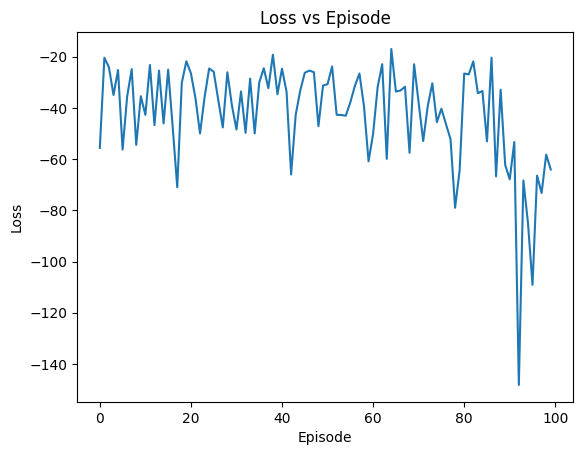

In [39]:
plot_loss(losses)

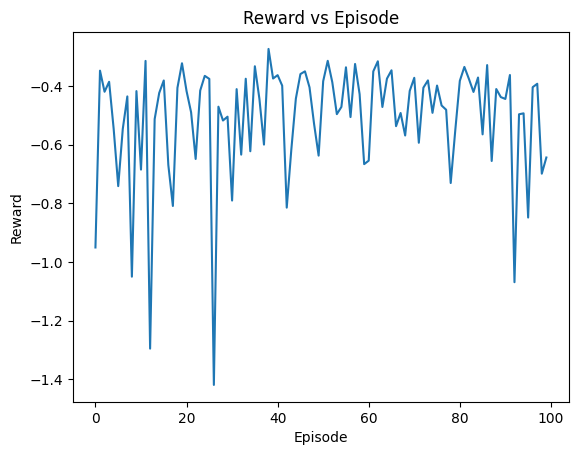

In [40]:
plot_reward(rewards)

In [41]:
prompt_text = "Explain reinforcement learning simply."
compare_generated_sequences(prompt_text, sft_model, rl_model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [42]:
prompt_text = "Tell me about reinforcement learning."
compare_generated_sequences(prompt_text, sft_model, rl_model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Setting 2:** REINFORCE Algorithm with advantage (baseline)

<!--From observing the output of the RL model compared to the SFT model, the generated texts looks like gibberish even though the loss seems to be going down. This phenomenon is known as reward hacking where the model loss is decreasing across episodes but the generated texts is gibberish. This happens because the model has figured out how to maximize the reward function without actually producing meaningul texts. -->

We observe  the loss and reward fluctuates alot, this is common phenomenon with the REINFORCE algorithm as proposed. It has higher variance because of the raw reward it uses.

To tackle the high variance problem, next we implement REINFORCE with advantage (baseline). The advantage is expressed as
$$\text{Advantage} = \text{Reward} - \text{Average Reward Baseline}$$

The advantage introduce simple moving average baseline to stabilize the reward. The loss becomes

$$
Loss = - E \bigg[ \sum_{t=1}^T \log \pi_\theta (a_t | s_t) \times \text{Advantage} \bigg]
$$

This transforms the high-variance raw reward into a lower-variance advantage signal, which is crucial for stabilizing Policy Gradient methods like REINFORCE.

In [43]:
rl_model_dataloader = DataLoader(rl_dataset, batch_size=5, shuffle=True)
rl_model_advantage, losses, rewards = train_rl_model(sft_model, rl_model_dataloader, use_advantage=True, num_epochs=10)


Reward: -0.4066
Baseline: 0.4547, Advantage: -0.8613
Sum Log Prob: -46.2250
Final Loss: -39.8114

Reward: -0.4360
Baseline: 0.4101, Advantage: -0.8462
Sum Log Prob: -95.0719
Final Loss: -80.4475

Reward: -0.8137
Baseline: 0.3489, Advantage: -1.1626
Sum Log Prob: -58.6528
Final Loss: -68.1906

Reward: -0.8782
Baseline: 0.2876, Advantage: -1.1658
Sum Log Prob: -41.8251
Final Loss: -48.7589

Reward: -0.3906
Baseline: 0.2537, Advantage: -0.6443
Sum Log Prob: -76.0161
Final Loss: -48.9768

Reward: -0.6076
Baseline: 0.2106, Advantage: -0.8182
Sum Log Prob: -66.2096
Final Loss: -54.1736

Reward: -0.6041
Baseline: 0.1699, Advantage: -0.7740
Sum Log Prob: -90.0269
Final Loss: -69.6779

Reward: -0.4611
Baseline: 0.1383, Advantage: -0.5995
Sum Log Prob: -79.7506
Final Loss: -47.8073

Reward: -0.4744
Baseline: 0.1077, Advantage: -0.5821
Sum Log Prob: -39.3700
Final Loss: -22.9172

Reward: -0.3752
Baseline: 0.0835, Advantage: -0.4587
Sum Log Prob: -94.0133
Final Loss: -43.1282
End of Epoch 0

Rewa

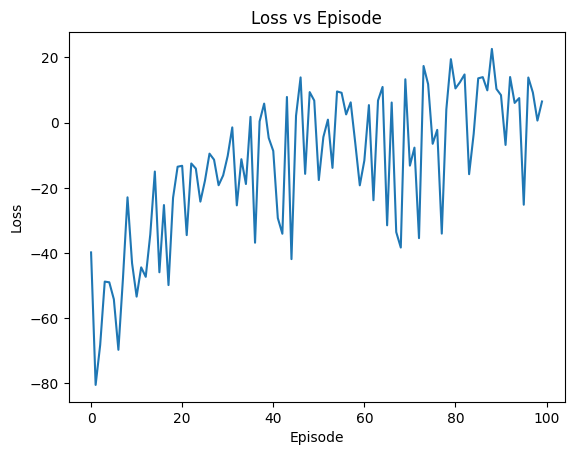

In [44]:
plot_loss(losses)

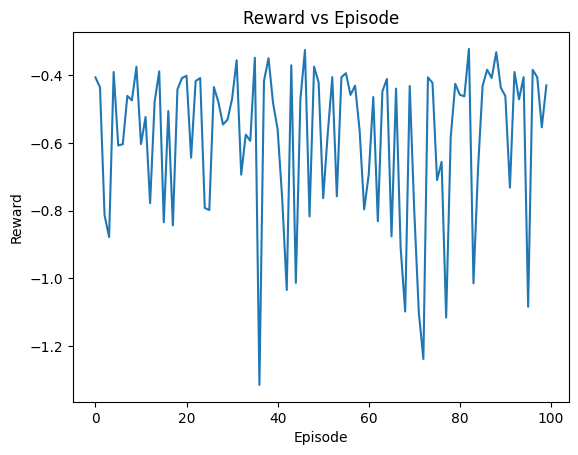

In [45]:
plot_reward(rewards)

In [46]:
prompt_text = "Explain reinforcement learning simply."
compare_generated_sequences(prompt_text, sft_model, rl_model_advantage)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [47]:
prompt_text = "Tell me about reinforcement learning."
compare_generated_sequences(prompt_text, sft_model, rl_model_advantage)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Setting 3:** Optimise the RL model with REINFORCE Algorithm with Advantage & KL loss

The reward and loss now look more stable. But we still see divergence in the generated text. To fix this, we implement KL divergence loss to penalise new policy for drifting too much from the reference model i.e the SFT model. This will prevent what we call catastrophic forgetting and ensure higher quality output.

$$
Loss = - E \bigg[ \sum_{t=1}^T \log \pi_\theta (a_t | s_t) \times \text{Advantage}\bigg] + \beta \times D_{KL}(\pi_\theta || \pi_{sft})
$$


In [48]:
rl_model_dataloader = DataLoader(rl_dataset, batch_size=5, shuffle=True)
rl_model_kl, losses, rewards = train_rl_model(sft_model.to(device), rl_model_dataloader, use_advantage=True, use_kl=True, num_epochs=10)


Reward: -0.4066
Baseline: 0.4547, Advantage: -0.8613
KL Divergence: 0.250803
Sum Log Prob: -59.4935
Final Loss: -51.2277

Reward: -0.4218
Baseline: 0.4108, Advantage: -0.8326
KL Divergence: 0.097676
Sum Log Prob: -41.2257
Final Loss: -34.3210

Reward: -0.4606
Baseline: 0.3673, Advantage: -0.8278
KL Divergence: 0.291388
Sum Log Prob: -59.3206
Final Loss: -49.0928

Reward: -0.4147
Baseline: 0.3282, Advantage: -0.7429
KL Divergence: 0.223512
Sum Log Prob: -66.6135
Final Loss: -49.4766

Reward: -0.9079
Baseline: 0.2664, Advantage: -1.1742
KL Divergence: 0.183264
Sum Log Prob: -54.5081
Final Loss: -63.9959

Reward: -0.4142
Baseline: 0.2323, Advantage: -0.6465
KL Divergence: 0.167421
Sum Log Prob: -61.6829
Final Loss: -39.8703

Reward: -0.5142
Baseline: 0.1950, Advantage: -0.7093
KL Divergence: 0.154746
Sum Log Prob: -49.6005
Final Loss: -35.1719

Reward: -0.3989
Baseline: 0.1653, Advantage: -0.5642
KL Divergence: 0.177540
Sum Log Prob: -63.2299
Final Loss: -35.6686

Reward: -0.4501
Baselin

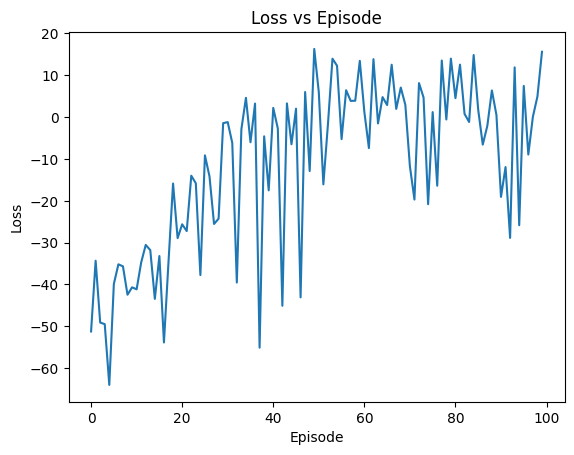

In [49]:
plot_loss(losses)

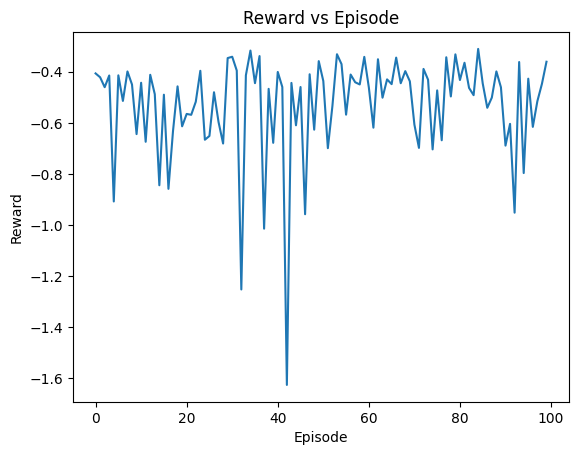

In [50]:
plot_reward(rewards)

In [51]:
prompt_text = "Explain reinforcement learning simply."
compare_generated_sequences(prompt_text, sft_model, rl_model_kl)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [52]:
prompt_text = "Tell me about reinforcement learning."
compare_generated_sequences(prompt_text, sft_model, rl_model_kl)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Bonus: Trying out "Like I'm 5 prompt"

In [53]:
prompt_text = "Explain reinforcement learning like I'm 5 years old." #@param {type:"string"}
compare_generated_sequences(prompt_text, pt_model, sft_model, model_1_name="PT", model_2_name="SFT")
compare_generated_sequences(prompt_text, None, rl_model, model_2_name="RL")
compare_generated_sequences(prompt_text, None, rl_model_advantage, model_2_name="RL+Adv")
compare_generated_sequences(prompt_text, None, rl_model_kl, model_2_name="RL+Adv+KL")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Congratulations, you've made it to the end!

We hope this tutorial has given you a practical understanding of how to optimise an SFT model using the REINFORCE algorithm. To further test your knowledge, try experimenting with different hyperparameters:

- Number of training epochs

- Batch size

- `beta` value when using REINFORCE with KL

- `gamma` for the moving average baseline

- Other advantage methods introduced in the lecture for Setting 2

Once you feel confident with REINFORCE, explore other RL algorithms such as PPO, GRPO, or DPO, and observe how the generated outputs differ. After that, think about other scenarios or datasets you might want to apply RL to, collect data, and train a model for those settings.

Good luck, and happy experimenting!